<a href="https://colab.research.google.com/github/elisasanzani/MachineLearningProject/blob/main/Zboson_decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

import numpy as np
import xgboost as xgb
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns

np.random.seed() # shuffle random seed generator



Getting data from my GitHub.
The datasets I am using are from [CERN Open Data](http://opendata.cern.ch/record/545)

These data were selected to obtain
* **a candidate Z boson event into 2 muons**: an event was selected if there were two muons in the event with pT > 20 GeV and |eta| < 2.1 and the invariant mass of the two muons was > 60 GeV and < 120 GeV.
* **a candidate Z boson event into 2 electrons**: an event was selected if there were two electrons in the event with pT > 25 GeV and the invariant mass of the two electrons was > 60 GeV and < 120 GeV





In [110]:
!wget https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zee.csv -O Zee.csv
!wget https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zmumu.csv -O Zmumu.csv

--2023-10-05 16:24:35--  https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zee.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1445651 (1.4M) [text/plain]
Saving to: ‘Zee.csv’

Zee.csv             100%[===================>]   1.38M  --.-KB/s    in 0.09s   

2023-10-05 16:24:36 (15.5 MB/s) - ‘Zee.csv’ saved [1445651/1445651]

--2023-10-05 16:24:36--  https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zmumu.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970550 (948K) [text/pl

# Let's prep the datasets

We can get rid of a few columns per dataset in order to simplify the training and to keep only featues which are useful to us. We will keep
* Run number (```Run```) and number of the (```Event```)
* The transverse momentum of the lepton (in units of GeV) (```pt```)
* The pseudorapidity of the lepton (```eta```)
* The phi angle (in radians) of the lepton (```phi```)
* The charge of the lepton (```Q```)

We also need to add a column with a flag (0 for Zee, 1 for Zmumu) to identify the two decay modes

## **Z → ee**

In [111]:
df_ee = pd.read_csv('Zee.csv') # read csv file
print(df_ee.shape)
print('Total number of events: ', len(df_ee), '\n')
df_ee.head()

(10000, 22)
Total number of events:  10000 



Run      Event      pt1    eta1    phi1  Q1 type1  sigmaEtaEta1  \
0  163286  109060857  37.5667  2.2892  2.0526  -1    EE        0.0251   
1  163286  109275715  36.2901 -0.8373 -1.5859   1    EB        0.0078   
2  163286  109075352  25.9705 -0.6974  1.6360  -1    EB        0.0097   
3  163286  109169766  41.0075  1.4619 -0.5325   1    EB        0.0088   
4  163286  108947653  39.8985 -0.5927 -2.3947   1    EB        0.0153   

   HoverE1  isoTrack1  ...      pt2    eta2    phi2  Q2  type2  sigmaEtaEta2  \
0   0.0090     0.0000  ...  45.4315  1.4706 -1.1630   1     EB        0.0008   
1   0.0438     0.0000  ...  60.5754 -0.4896  1.0496  -1     EB        0.0112   
2   0.0407     6.2870  ...  45.2954 -2.0401  3.1187   1     EE        0.0260   
3   0.0000     0.0000  ...  45.9013  1.1561  2.4786  -1     EB        0.0086   
4   0.0000     2.5435  ...  34.8931 -2.2444  0.6106  -1     EE        0.0290   

  HoverE2  isoTrack2  isoEcal2  isoHcal2  
0   0.000     0.0000    1.0190    0.0000  
1   0.000     0.7185    1.8461    0.0000  
2   0.028    15.2170    4.5337    3.8370  
3   0.000     0.0000    2.4388    0.5676  
4   0.000    12.4229    0.4534    0.9096  

[5 rows x 22 columns]

In [112]:
print ('Before dropping columns: \n',  list(df_ee.columns))
df_ee = df_ee.drop(['type1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1', 'isoEcal1', 'isoHcal1', 'type2', 'sigmaEtaEta2', 'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2'], axis=1) # remove unwanted column with just increasing int
print ('After dropping columns: \n', list(df_ee.columns))
print ('\n\nAdding flag column')
df_ee['flag'] = 0
df_ee.head()

Before dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'type1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1', 'isoEcal1', 'isoHcal1', 'pt2', 'eta2', 'phi2', 'Q2', 'type2', 'sigmaEtaEta2', 'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2']
After dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'pt2', 'eta2', 'phi2', 'Q2']


Adding flag column


Run      Event      pt1    eta1    phi1  Q1      pt2    eta2    phi2  \
0  163286  109060857  37.5667  2.2892  2.0526  -1  45.4315  1.4706 -1.1630   
1  163286  109275715  36.2901 -0.8373 -1.5859   1  60.5754 -0.4896  1.0496   
2  163286  109075352  25.9705 -0.6974  1.6360  -1  45.2954 -2.0401  3.1187   
3  163286  109169766  41.0075  1.4619 -0.5325   1  45.9013  1.1561  2.4786   
4  163286  108947653  39.8985 -0.5927 -2.3947   1  34.8931 -2.2444  0.6106   

   Q2  flag  
0   1     0  
1  -1     0  
2   1     0  
3  -1     0  
4  -1     0

## **Z → 𝜇𝜇**

In [113]:
df_mumu = pd.read_csv('Zmumu.csv') # read csv file
print(df_mumu.shape)
print('Total number of events: ', len(df_mumu), '\n')
df_mumu.head()

(10000, 14)
Total number of events:  10000 



Run     Event      pt1    eta1    phi1  Q1    dxy1    iso1      pt2  \
0  165617  74969122  54.7055 -0.4324  2.5742   1 -0.0745  0.4999  34.2464   
1  165617  75138253  24.5872 -2.0522  2.8666  -1 -0.0554  0.0000  28.5389   
2  165617  75887636  31.7386 -2.2595 -1.3323  -1  0.0879  0.0000  30.2344   
3  165617  75779415  39.7394 -0.7123 -0.3123   1  0.0585  0.0000  48.2790   
4  165617  75098104  41.2998 -0.1571 -3.0408   1 -0.0305  1.2280  43.4508   

     eta2    phi2  Q2    dxy2    iso2  
0 -0.9885 -0.4987  -1  0.0712  3.4221  
1  0.3852 -1.9912   1  0.0515  0.0000  
2 -0.4684  1.8833   1 -0.0876  0.0000  
3 -0.1956  2.9703  -1 -0.0492  0.0000  
4  0.5910 -0.0428  -1  0.0442  0.0000

In [114]:
print ('Before dropping columns: \n',  list(df_mumu.columns))
df_mumu = df_mumu.drop(['dxy1', 'iso1', 'dxy2', 'iso2'], axis=1) # remove unwanted column with just increasing int
print ('After dropping columns: \n', list(df_mumu.columns))
print ('\n\nAdding flag column')
df_mumu['flag'] = 1
df_mumu.head()

Before dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'dxy1', 'iso1', 'pt2', 'eta2', 'phi2', 'Q2', 'dxy2', 'iso2']
After dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'pt2', 'eta2', 'phi2', 'Q2']


Adding flag column


Run     Event      pt1    eta1    phi1  Q1      pt2    eta2    phi2  Q2  \
0  165617  74969122  54.7055 -0.4324  2.5742   1  34.2464 -0.9885 -0.4987  -1   
1  165617  75138253  24.5872 -2.0522  2.8666  -1  28.5389  0.3852 -1.9912   1   
2  165617  75887636  31.7386 -2.2595 -1.3323  -1  30.2344 -0.4684  1.8833   1   
3  165617  75779415  39.7394 -0.7123 -0.3123   1  48.2790 -0.1956  2.9703  -1   
4  165617  75098104  41.2998 -0.1571 -3.0408   1  43.4508  0.5910 -0.0428  -1   

   flag  
0     1  
1     1  
2     1  
3     1  
4     1

## Now we can shuffle the datasets to create a single one and look at the overall distributions




In [115]:
df_all = pd.concat([df_ee, df_mumu], ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all.head()

Run      Event      pt1    eta1    phi1  Q1      pt2    eta2    phi2  \
0  166784   20257329  42.9130 -1.3248 -3.0057  -1  42.2897 -0.6624  0.3485   
1  163261   64679856  39.8744 -0.0057 -0.7744  -1  36.3997  1.3710  2.2952   
2  165570  196860468  72.9296 -0.4162  0.9198   1  39.5410 -0.2680 -1.4629   
3  172163  497791581  33.4436  0.3063 -1.6034   1  27.2395 -1.6182  1.5315   
4  173692  550966077  43.9826  0.4276 -0.3876  -1  29.7856 -0.3080  2.8965   

   Q2  flag  
0   1     1  
1   1     0  
2   1     0  
3  -1     0  
4   1     1

It is also better to check is there are zeros of NaN

In [116]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     20000 non-null  int64  
 1   Event   20000 non-null  int64  
 2   pt1     20000 non-null  float64
 3   eta1    20000 non-null  float64
 4   phi1    20000 non-null  float64
 5   Q1      20000 non-null  int64  
 6   pt2     20000 non-null  float64
 7   eta2    20000 non-null  float64
 8   phi2    20000 non-null  float64
 9   Q2      20000 non-null  int64  
 10  flag    20000 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.7 MB


In [117]:
nan_check = df_all.isna()
if nan_check.any().any():
    print("The DataFrame contains NaN values in these rows:")
    rows_with_nan = df_all[df_all[df_all.columns[:-1]].isna().any(axis=1)]
else:
    print("The DataFrame does not contain NaN values.")

zero_check = (df_all[df_all.columns[:-1]] == 0.00)
if zero_check.any().any():
    print("The DataFrame contains zero values in these rows:")
    rows_with_zeros = df_all[df_all[df_all.columns[:-1]].eq(0).any(axis=1)]
    print(rows_with_zeros)
else:
    print("The DataFrame does not contain zero values.")


The DataFrame does not contain NaN values.
The DataFrame contains zero values in these rows:
          Run      Event      pt1  eta1    phi1  Q1      pt2    eta2    phi2  \
11198  173381  209714969  39.1714   0.0 -2.9318  -1  52.2589  0.1797  0.1143   

       Q2  flag  
11198   1     1  


There is one zero value, but pseudorapidity can assume that value (direction perpendicular wrt beam pipe) and this does not appear to be a bad event, so we'll keep it.

It is also important to notice that the dataset is well balanced in the two possible classes (10000 events each)

# Data visualisation

## Features distributions

<Figure size 2000x1500 with 0 Axes>

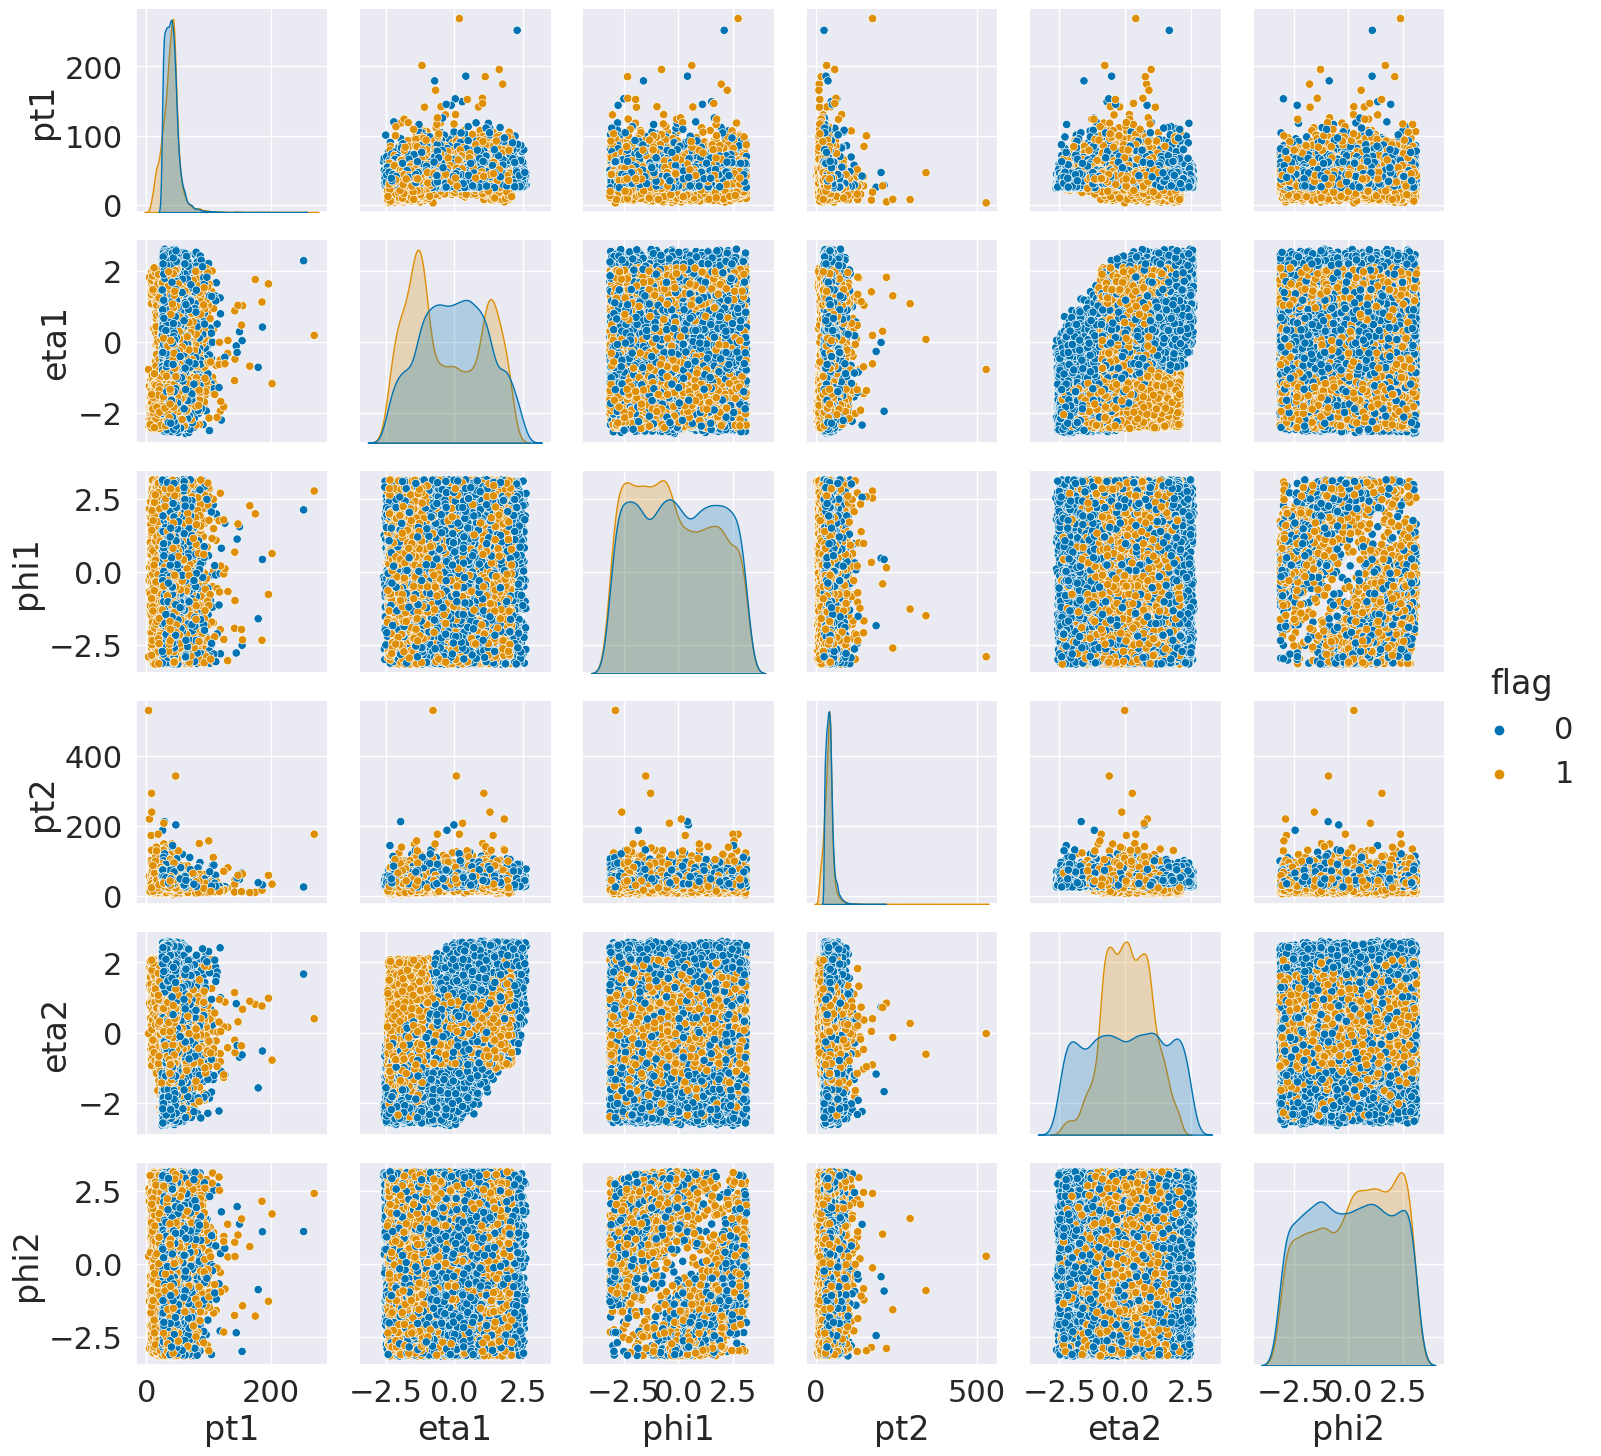

In [118]:
df_reduced = df_all[['pt1', 'eta1', 'phi1', 'pt2', 'eta2', 'phi2', 'flag']]
plt.figure(figsize=(20, 15))
sns.set(font_scale=2.0)
sns.pairplot(df_reduced, hue="flag", palette="colorblind")

In [119]:
#what if I take the log of pT, is it better?
df_all["log(pt1)"] = df_all.pt1.apply(np.log1p)
df_all["log(pt2)"] = df_all.pt2.apply(np.log1p)
df_all = df_all.drop(['pt1', 'pt2'], axis=1)
df_all.head()

Run      Event    eta1    phi1  Q1    eta2    phi2  Q2  flag  log(pt1)  \
0  166784   20257329 -1.3248 -3.0057  -1 -0.6624  0.3485   1     1  3.782210   
1  163261   64679856 -0.0057 -0.7744  -1  1.3710  2.2952   1     0  3.710504   
2  165570  196860468 -0.4162  0.9198   1 -0.2680 -1.4629   1     0  4.303113   
3  172163  497791581  0.3063 -1.6034   1 -1.6182  1.5315  -1     0  3.539323   
4  173692  550966077  0.4276 -0.3876  -1 -0.3080  2.8965   1     1  3.806276   

   log(pt2)  
0  3.767915  
1  3.621663  
2  3.702314  
3  3.340722  
4  3.427047

<Figure size 2000x1500 with 0 Axes>

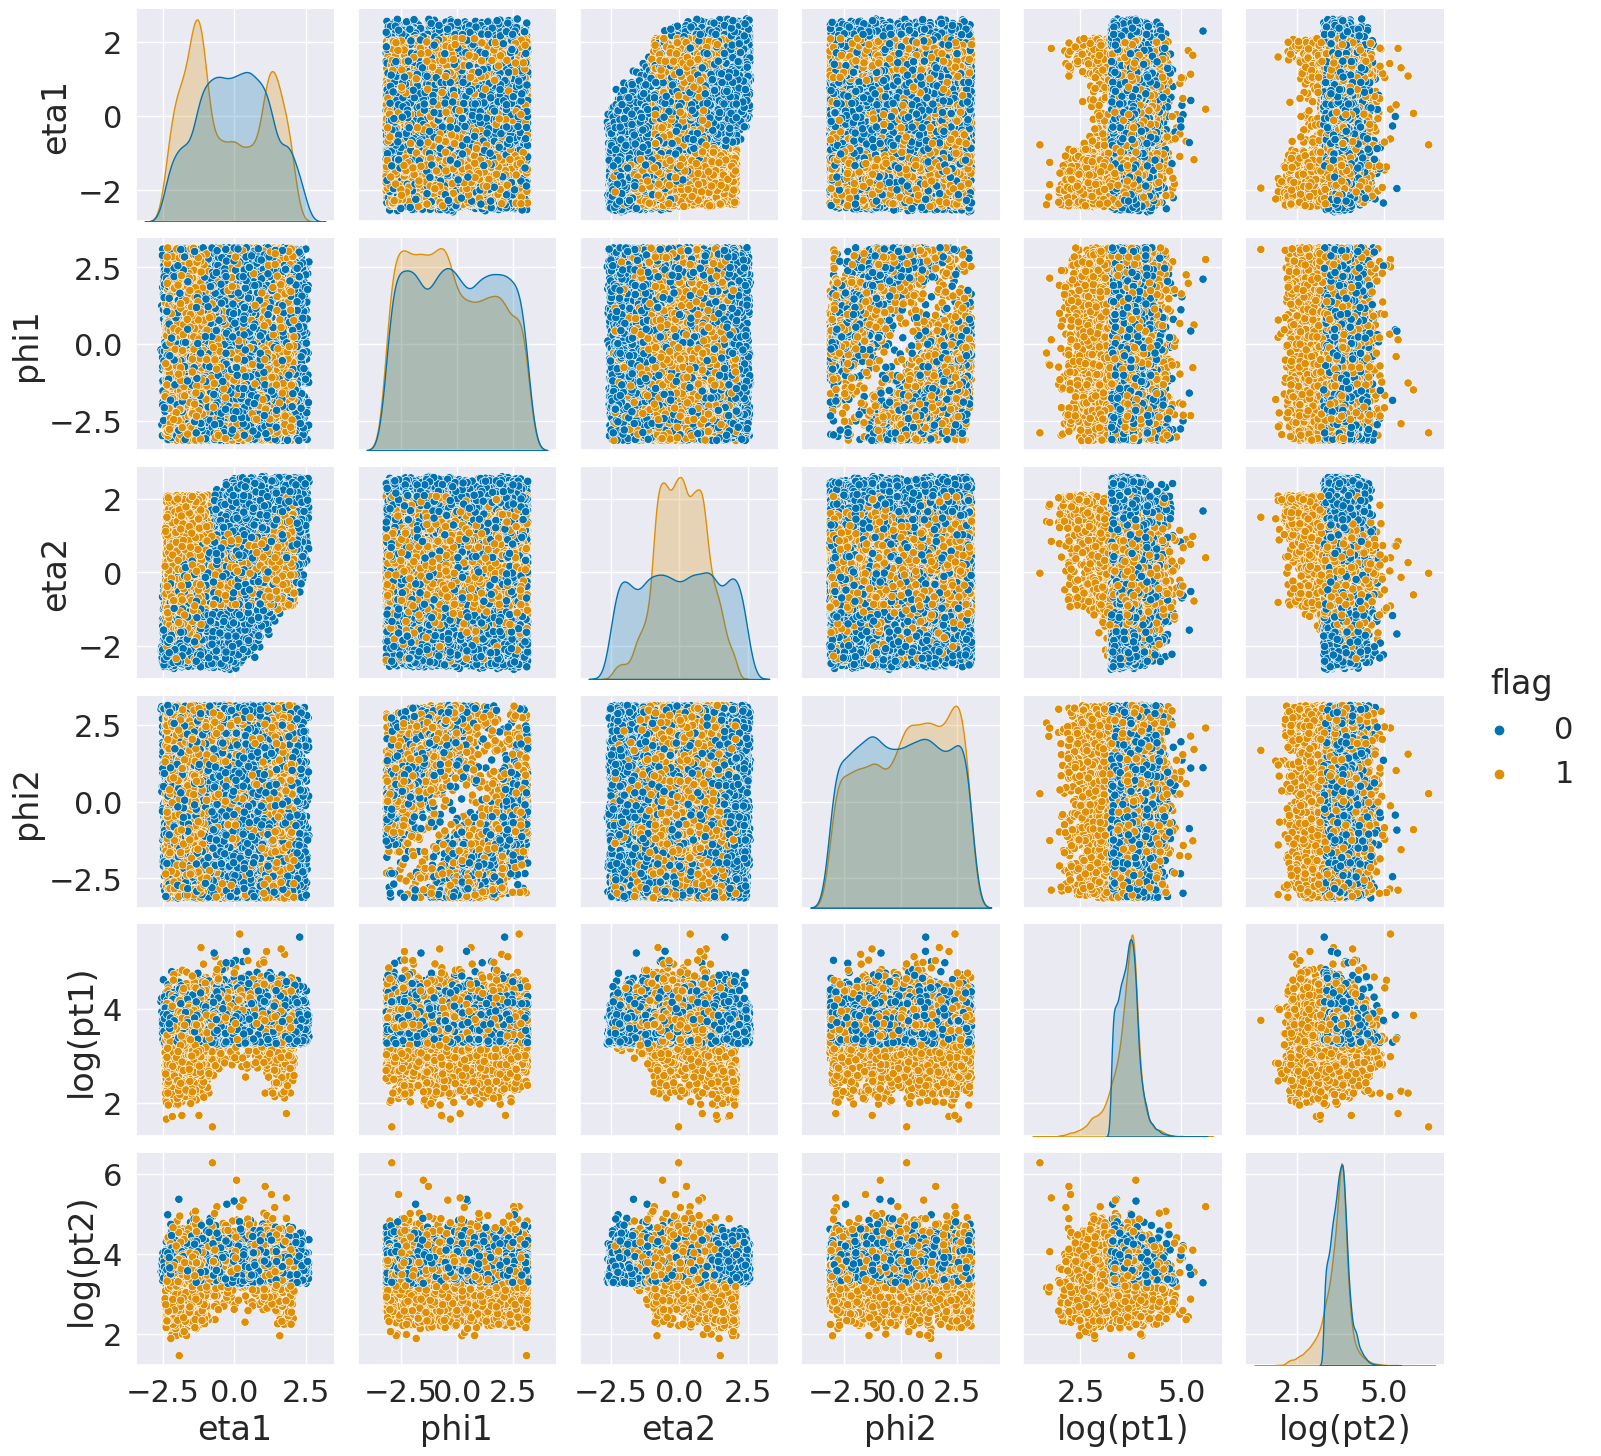

In [120]:
df_reduced2 = df_all[['eta1', 'phi1', 'eta2', 'phi2', 'flag', 'log(pt1)', 'log(pt2)']]
plt.figure(figsize=(20, 15))
sns.set(font_scale=2.0)
sns.pairplot(df_reduced2, hue="flag", palette="colorblind")

In [121]:
#I want to try using the difference in eta and not just eta, out of curiosity
df_all["etaDiff"] = df_all['eta1'] - df_all['eta2']
df_all = df_all.drop(['eta1', 'eta2'], axis=1)
df_all.head()

Run      Event    phi1  Q1    phi2  Q2  flag  log(pt1)  log(pt2)  \
0  166784   20257329 -3.0057  -1  0.3485   1     1  3.782210  3.767915   
1  163261   64679856 -0.7744  -1  2.2952   1     0  3.710504  3.621663   
2  165570  196860468  0.9198   1 -1.4629   1     0  4.303113  3.702314   
3  172163  497791581 -1.6034   1  1.5315  -1     0  3.539323  3.340722   
4  173692  550966077 -0.3876  -1  2.8965   1     1  3.806276  3.427047   

   etaDiff  
0  -0.6624  
1  -1.3767  
2  -0.1482  
3   1.9245  
4   0.7356

<Figure size 2000x1500 with 0 Axes>

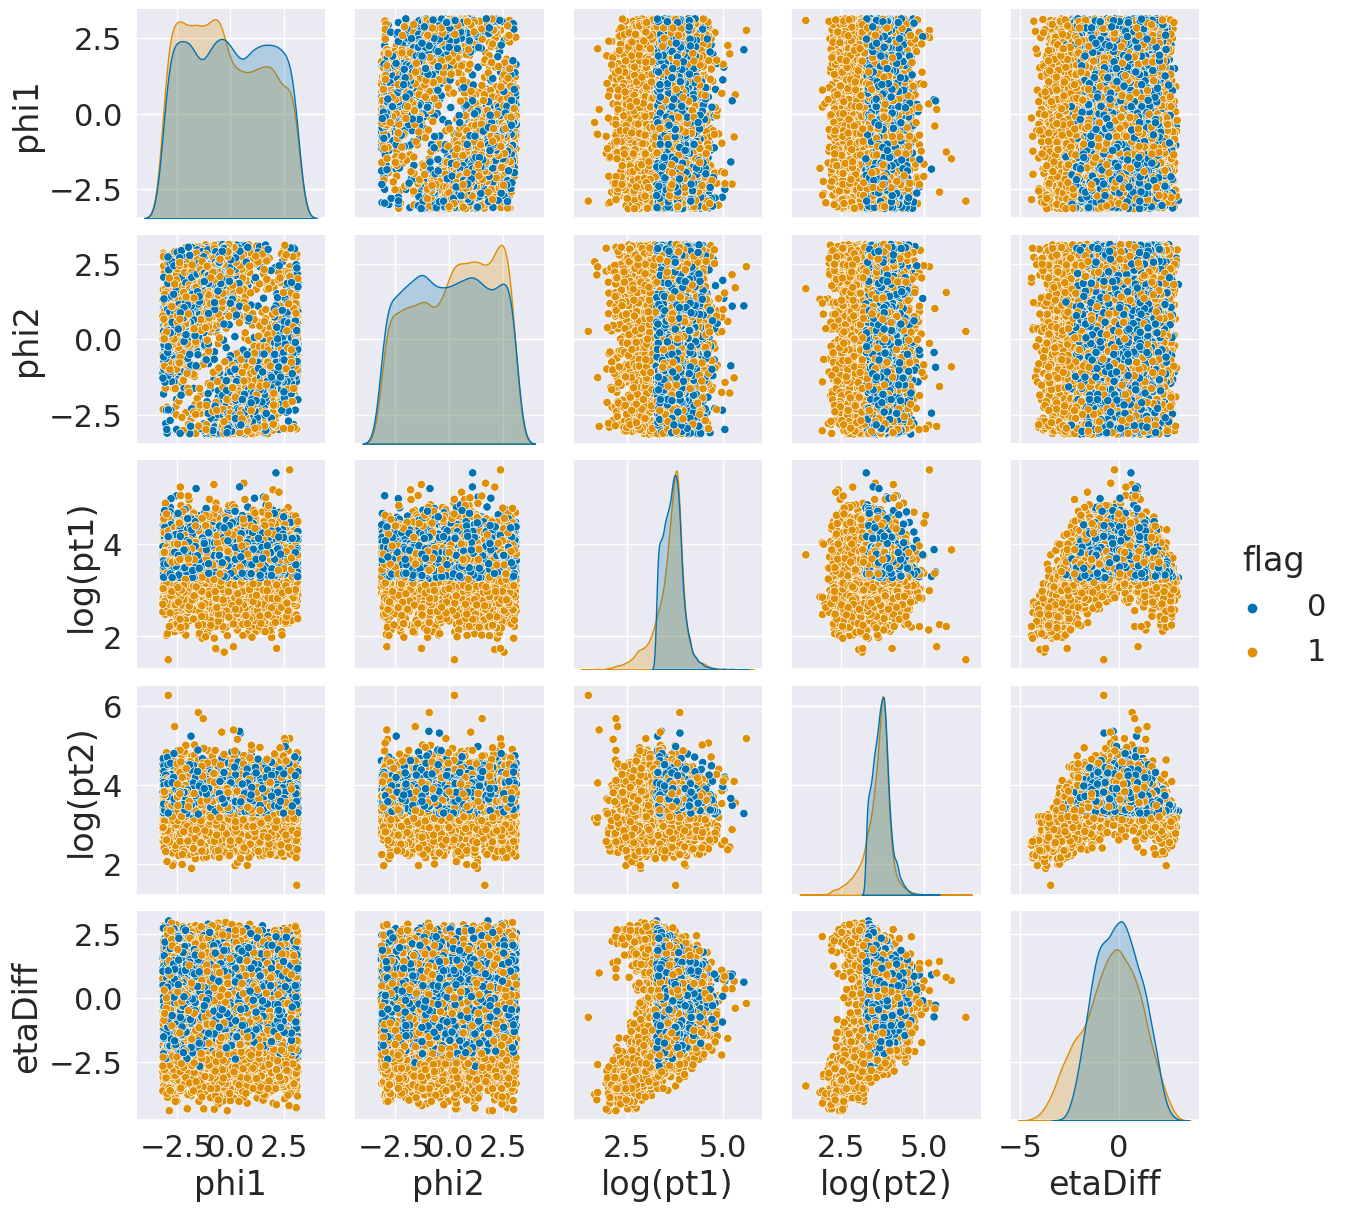

In [122]:
df_reduced3 = df_all[['phi1', 'phi2', 'flag', 'log(pt1)', 'log(pt2)', 'etaDiff']]
plt.figure(figsize=(20, 15))
sns.set(font_scale=2.0)
sns.pairplot(df_reduced3, hue="flag", palette="colorblind")

Looking at the distributions. Does not appear that much interesting but I may try it anyway

## Density plots